In [2]:
%matplotlib inline

import warnings
from datetime import datetime
import os
from pathlib import Path
import quandl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets
from pyfinance.ols import PandasRollingOLS
from sklearn.feature_selection import mutual_info_classif

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
idx = pd.IndexSlice

## Get Data

The `assets.h5` store can be generated using the `get_data.py` script in the `data` folder in the root directory of this repo.

In [8]:
with pd.HDFStore('../../data/assets.h5') as store:
    prices = store['quandl/wiki/prices'].loc[idx['2000':'2018', :], 'adj_close'].unstack('ticker')
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]
    stocks = stocks[~stocks.index.duplicated()]

### Keep data with stock info

In [9]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
marketcap    5766 non-null float64
ipoyear      3038 non-null float64
sector       5288 non-null object
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


In [10]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


## Create monthly return series

Winsorize outliers

In [11]:
monthly_prices = prices.resample('M').last()

In [12]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 521806 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 6 columns):
return_1m     521806 non-null float64
return_2m     521806 non-null float64
return_3m     521806 non-null float64
return_6m     521806 non-null float64
return_9m     521806 non-null float64
return_12m    521806 non-null float64
dtypes: float64(6)
memory usage: 25.9+ MB


## Drop stocks with less than 10 yrs of returns

In [13]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 6 columns):
return_1m     465935 non-null float64
return_2m     465935 non-null float64
return_3m     465935 non-null float64
return_6m     465935 non-null float64
return_9m     465935 non-null float64
return_12m    465935 non-null float64
dtypes: float64(6)
memory usage: 23.1+ MB


In [14]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,465935.000000,465935.000000,465935.000000,465935.000000,465935.000000,465935.000000
mean,0.011694,0.008454,0.007306,0.006036,0.005542,0.005285
std,0.117872,0.084059,0.069195,0.050674,0.041919,0.036635
min,-0.343442,-0.269341,-0.229978,-0.175426,-0.145071,-0.125787
25%,-0.046679,-0.031096,-0.024413,-0.015632,-0.012035,-0.009962
50%,0.006369,0.007476,0.007810,0.008024,0.007924,0.007852
75%,0.065314,0.048890,0.041722,0.031742,0.027062,0.024439
max,0.449446,0.294075,0.230064,0.159207,0.128147,0.108809


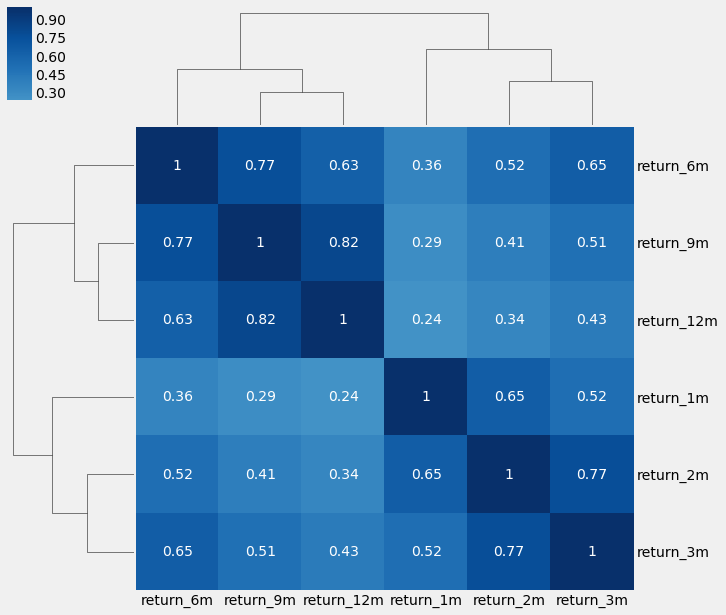

In [15]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

In [16]:
data.index.get_level_values('ticker').nunique()

2385

## Rolling Factor Betas

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [17]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 226 entries, 2000-01-31 to 2018-10-31
Freq: M
Data columns (total 5 columns):
Mkt-RF    226 non-null float64
SMB       226 non-null float64
HML       226 non-null float64
RMW       226 non-null float64
CMA       226 non-null float64
dtypes: float64(5)
memory usage: 10.6 KB


In [18]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 6 columns):
Mkt-RF       465935 non-null float64
SMB          465935 non-null float64
HML          465935 non-null float64
RMW          465935 non-null float64
CMA          465935 non-null float64
return_1m    465935 non-null float64
dtypes: float64(6)
memory usage: 23.1+ MB


In [19]:
T = 24
betas = (factor_data
         .groupby(level='ticker', group_keys=False)
         .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), y=x.return_1m, x=x.drop('return_1m', axis=1)).beta))

In [20]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,411080.000000,411080.000000,411080.000000,411080.000000,411080.000000,411080.000000
mean,0.973212,0.637654,0.115784,-0.104235,0.013401,1.635815
std,0.950562,1.299055,1.637548,2.054953,2.270667,3.693460
min,-9.433446,-10.325247,-16.017401,-26.596829,-20.610665,-37.961078
25%,0.426304,-0.115787,-0.719114,-1.070525,-1.121108,-0.220352
50%,0.918170,0.543187,0.075439,0.000000,0.021998,1.559403
75%,1.461376,1.332415,0.932056,0.968201,1.161241,3.509517
max,10.247627,10.743238,14.065201,18.232822,18.704300,35.582264


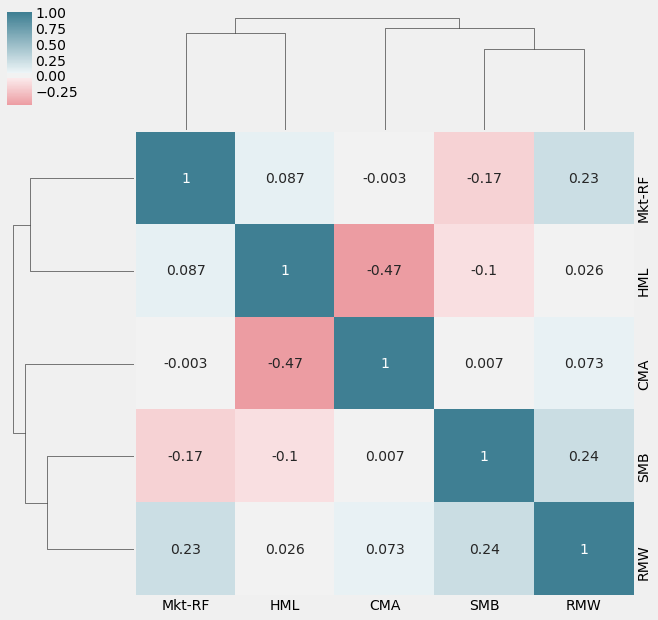

In [21]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [22]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 11 columns):
return_1m     465935 non-null float64
return_2m     465935 non-null float64
return_3m     465935 non-null float64
return_6m     465935 non-null float64
return_9m     465935 non-null float64
return_12m    465935 non-null float64
Mkt-RF        408695 non-null float64
SMB           408695 non-null float64
HML           408695 non-null float64
RMW           408695 non-null float64
CMA           408695 non-null float64
dtypes: float64(11)
memory usage: 60.9+ MB


### Impute mean for missing factor betas

In [23]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 11 columns):
return_1m     465935 non-null float64
return_2m     465935 non-null float64
return_3m     465935 non-null float64
return_6m     465935 non-null float64
return_9m     465935 non-null float64
return_12m    465935 non-null float64
Mkt-RF        465935 non-null float64
SMB           465935 non-null float64
HML           465935 non-null float64
RMW           465935 non-null float64
CMA           465935 non-null float64
dtypes: float64(11)
memory usage: 60.9+ MB


## Momentum factors

In [24]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

## Date Indicators

In [25]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

In [26]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
# data = data.dropna(thresh=int(len(data.columns) * outlier_threshold))
# data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 25 columns):
return_1m        465935 non-null float64
return_2m        465935 non-null float64
return_3m        465935 non-null float64
return_6m        465935 non-null float64
return_9m        465935 non-null float64
return_12m       465935 non-null float64
Mkt-RF           465935 non-null float64
SMB              465935 non-null float64
HML              465935 non-null float64
RMW              465935 non-null float64
CMA              465935 non-null float64
momentum_2       465935 non-null float64
momentum_3       465935 non-null float64
momentum_6       465935 non-null float64
momentum_9       465935 non-null float64
momentum_12      465935 non-null float64
momentum_3_12    465935 non-null float64
year             465935 non-null int64
month            465935 non-null int64
return_1m_t-1    463550 non-null float64
return_1m_t-2    461165 non-n

## Target: Holding Period Returns

In [27]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [28]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.340055      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.340055  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 30 columns):
return_1m        465935 non-null float64
return_2m        465935 non-null float64
return_3m        465935 non-null float64
return_6m        465935 non-null float64
return_9m        465935 non-null float64
return_12m       465935 non-null float64
Mkt-RF           465935 non-null float64
SMB              465935 non-null float64
HML              465935 non-null float64
RMW              465935 non-null float64
CMA              465935 non-null float64
momentum_2       465935 non-null float64
momentum_3       465935 non-null float64
momentum_6       465935 non-null float64
momentum_9       465935 non-null float64
momentum_12      465935 non-null float64
momentum_3_12    465935 non-null float64
year             465935 non-null int64
month            465935 non-null int64
return_1m_t-1    463550 non-null float64
return_1m_t-2    461165 non-n

## Create age proxy

In [30]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

## Create dynamic size proxy

In [32]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
marketcap    5766 non-null float64
ipoyear      3038 non-null float64
sector       5288 non-null object
dtypes: float64(2), object(1)
memory usage: 533.6+ KB


In [31]:
stocks.marketcap = stocks.marketcap.str.replace('$', '')
stocks['mcap'] = stocks.marketcap.str[-1]
stocks.marketcap =  pd.to_numeric(stocks.marketcap.str[:-1])
stocks = stocks[stocks.mcap.isin(['B', 'M'])]
stocks.info()

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [ ]:
stocks.marketcap = stocks.apply(lambda x: x.marketcap * 1000 if x.mcap == 'B' else x.marketcap, axis=1)
stocks.marketcap.describe()

In [ ]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

In [ ]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')

In [ ]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

## Combine data

In [ ]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [ ]:
data.info()

## Store data

In [ ]:
with pd.HDFStore('../../data/data.h5') as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])

## Create Dummy variables

In [ ]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

### Mutual Information

#### Original Data

In [ ]:
target_labels = [f'target_{i}m' for i in [1,2,3,6,12]]
targets = data.dropna().loc[:, target_labels]

features = data.dropna().drop(target_labels, axis=1)
features.sector = pd.factorize(features.sector)[0]

cat_cols = ['year', 'month', 'msize', 'age', 'sector']
discrete_features = [features.columns.get_loc(c) for c in cat_cols]

In [ ]:
mutual_info = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=features, 
                             y=(targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )
    mutual_info[label] = pd.Series(mi, index=features.columns)

In [ ]:
mutual_info.sum()

#### Normalized MI Heatmap

In [ ]:
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');

#### Dummy Data

In [ ]:
target_labels = [f'target_{i}m' for i in [1, 2, 3, 6, 12]]
dummy_targets = dummy_data.dropna().loc[:, target_labels]

dummy_features = dummy_data.dropna().drop(target_labels, axis=1)
cat_cols = [c for c in dummy_features.columns if c not in features.columns]
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

In [ ]:
mutual_info_dummies = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=dummy_features, 
                             y=(dummy_targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )    
    mutual_info_dummies[label] = pd.Series(mi, index=dummy_features.columns)

In [ ]:
mutual_info_dummies.sum()

In [ ]:
fig, ax= plt.subplots(figsize=(4, 20))
sns.heatmap(mutual_info_dummies.div(mutual_info_dummies.sum()), ax=ax, cmap='Blues');